In [16]:
!pip install sentencepiece
!pip install tokenizers
!pip install transformers
import numpy as np
import tensorflow as tf
import csv
from keras.preprocessing.sequence import pad_sequences
from io import StringIO
import sentencepiece as spm
import argparse
from tokenizers import BertWordPieceTokenizer
from transformers import AutoTokenizer, AutoModelWithLMHead

In [17]:
!rm -rf SentimentAnalysis
!git clone https://github.com/yjbong/SentimentAnalysis.git
!cp ./SentimentAnalysis/Korean/Data/* .

Cloning into 'SentimentAnalysis'...
remote: Enumerating objects: 21, done.
remote: Counting objects: 100% (21/21), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 21 (delta 0), reused 21 (delta 0), pack-reused 0
Unpacking objects: 100% (21/21), done.


In [18]:
# Base Model (108M)
#tokenizer = AutoTokenizer.from_pretrained("beomi/kcbert-base")
#model = AutoModelWithLMHead.from_pretrained("beomi/kcbert-base")

# Large Model (334M)
tokenizer = AutoTokenizer.from_pretrained("beomi/kcbert-large")
model = AutoModelWithLMHead.from_pretrained("beomi/kcbert-large")

/usr/local/lib/python3.6/dist-packages/transformers/models/auto/modeling_auto.py:890: FutureWarning: The class `AutoModelWithLMHead` is deprecated and will be removed in a future version. Please use `AutoModelForCausalLM` for causal language models, `AutoModelForMaskedLM` for masked language models and `AutoModelForSeq2SeqLM` for encoder-decoder models.
  FutureWarning,
Some weights of the model checkpoint at beomi/kcbert-large were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification m

In [19]:
idx = 1
word2Idx = {}
X_value = []
X_label = []
MAX_SEQUENCE_LEN = 0

with open('ko_train_data.csv', 'r', newline='', encoding='utf-8') as csvfile:
  data = csvfile.read()
  # null 문자 처리
  data = data.replace('\x00','')

  # 파일 읽기
  reader = csv.DictReader(StringIO(data))
  for row in reader:
    sequence = []
    value = []
    if row['label'] == None or len(row['label']) != 1:
      continue

    X_label.append(ord(row['label'])-48)

    sentence = tokenizer.tokenize(row['document'][:300])
    for word in sentence:
      if word not in word2Idx:
        word2Idx[word] = idx
        idx = idx + 1
      value.append(word2Idx[word])
    X_value.append(value)

    if MAX_SEQUENCE_LEN < len(value):
      MAX_SEQUENCE_LEN = len(value)

# 가장 긴 sequence의 길이로 padding
X = pad_sequences(X_value, padding='post', maxlen=MAX_SEQUENCE_LEN) #패딩진행

vocab_size = len(word2Idx) + 1 # 0번 포함
embedding_dim = 512

embedding_matrix = np.zeros((vocab_size, embedding_dim))
for i in range(1,len(word2Idx)+1):
  embedding_matrix[i] = np.random.rand(embedding_dim)*2-1

In [20]:
from keras.models import Sequential
from keras import layers
from keras.models import Model

test_data_ratio = 0.2
boundary = int((1.0-test_data_ratio) * len(X))
X_train = X[:boundary]
X_train_label = X_label[:boundary]
X_test = X[boundary:]
X_test_label = X_label[boundary:]

seq_input = layers.Input(shape=(MAX_SEQUENCE_LEN,), dtype='int32')

seq_embedded = layers.Embedding(vocab_size, 
                           embedding_dim, 
                           weights=[embedding_matrix], 
                           input_length=MAX_SEQUENCE_LEN, 
                           trainable=True)(seq_input)

conv_layer = layers.Conv1D(filters=100, 
                            kernel_size=[3], 
                            activation='relu',
                            padding='valid')(seq_embedded) # Convolution Layer
pooled_layer = layers.GlobalMaxPooling1D()(conv_layer) # Pooling Layer (Max Pooling)

model_output = layers.Dropout(0.2)(pooled_layer) # Drop out 적용

model_output = layers.Dense(10, activation='relu')(model_output)
logits = layers.Dense(1, activation='sigmoid')(model_output)

model = Model(seq_input, logits) #(입력,출력)
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

#학습 시작
history = model.fit(np.array(X_train), np.array(X_train_label),
                    epochs=3,
                    verbose=True,
                    validation_data=(np.array(X_test), np.array(X_test_label)),
                    #validation_data = None,
                    batch_size=128)
print(history.history)

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 140)]             0         
_________________________________________________________________
embedding_3 (Embedding)      (None, 140, 512)          10482688  
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 138, 100)          153700    
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 100)               0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 10)                1010      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 11  

In [21]:
 from keras.models import load_model
model.save('SentimentModel') #모델 저장하기

#모델 평가
test_loss,test_acc=model.evaluate(np.array(X_test),np.array(X_test_label))
print("Test_acc: ",test_acc)

INFO:tensorflow:Assets written to: SentimentModel/assets
367/367 [==============================] - 12s 34ms/step - loss: 0.3916 - accuracy: 0.8305
Test_acc:  0.830463707447052


In [23]:
import pandas as pd

loaded_model = load_model('SentimentModel')
sentimentId=[]
sentimentResult=[]
with open('ko_data.csv', 'r', newline='', encoding='CP949') as csvfile:
  data = csvfile.read()
  # null 문자 처리
  data = data.replace('\x00','')

  # 파일 읽기
  reader = csv.DictReader(StringIO(data))
  for row in reader:
    sequence = []
    value = []
    sentenceToPredict = row['Sentence']
    words = tokenizer.tokenize(sentenceToPredict)

    for word in words:
      if word in word2Idx:
        curIdx = word2Idx[word]
      else:
        curIdx = 0
      value.append(curIdx)

    padded_value = pad_sequences([value], padding='post', maxlen=MAX_SEQUENCE_LEN) #패딩진행
    score = float(loaded_model.predict(padded_value)) # 예측
    if score>0.5:
      sentimentResult.append(1) # 긍정 분류
    else:
      sentimentResult.append(0) # 부정 분류

    sentimentId.append(row['Id'])

# 결과를 csv에 쓰기
resultData = pd.DataFrame()
resultData['Id'] = sentimentId
resultData['Predicted'] = sentimentResult
resultData.to_csv('result.csv', sep=',', index=False)

In [24]:
# 결과 파일 다운로드
from google.colab import files
files.download("result.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

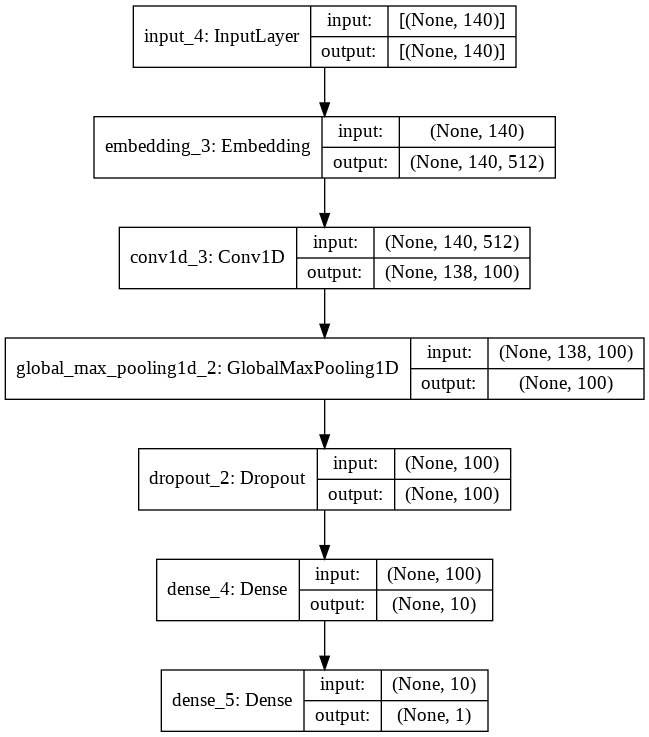

In [25]:
from keras.utils.vis_utils import plot_model
loaded_model = load_model('SentimentModel')
plot_model(loaded_model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)